## Compiling markdown records to a single spreadsheet

In [1]:
import os
import markdown
import pandas as pd
from bs4 import BeautifulSoup
from tqdm import tqdm


def markdown_to_text(markdown_string):
    html = markdown.markdown(markdown_string)
    text = ''.join(BeautifulSoup(html, "html.parser").findAll(string=True))
    return text


def get_generated_record(index: int) -> str:
    file_path = f'{results_dir}/{index}.md'
    with open(file_path, 'r') as fp:
        return fp.read()

parent_dir = os.path.dirname(os.getcwd())

languages = [
    'english simplified',
    'english super simplified',
    'mandarin simplified',
    'spanish simplified',
    'arabic simplified',
    'hindi simplified',
    'bengali simplified',
    'portuguese simplified',
    'russian simplified',
    'japanese simplified',
    'punjabi simplified'
]

### PubMed

In [2]:
data_dir = f'{parent_dir}/data'
results_dir = f'{parent_dir}/gemini_output/markdown_pubmed'
df = pd.read_csv(f'{data_dir}/PubMed_articles_cleaned.tsv', sep='\t')
abstracts = df['abstract'].tolist()
gen_record_indices = [int(n.split('.')[0]) for n in os.listdir(results_dir) if '.md' in n]

In [3]:
df['#words'] = [len(a.strip().split(' ')) for a in df['abstract'].tolist()]
df.describe()

,#words
count,40883.000000
mean,220.772864
std,85.259271
min,1.000000
25%,162.000000
50%,225.000000
75%,269.000000
max,1146.000000


In [4]:
processed_records = list()
failures = list() # Unsafe outputs

for index in tqdm(gen_record_indices):
    md = get_generated_record(index)
    sections = markdown_to_text(md).split('\n')
    json = {'original': abstracts[index]}
    i = 1
    while i < len(sections)-1:
        lang = sections[i].lower().strip()
        if not lang in languages:
            break
        else:
            # Handle both single para and multi-para
            next_i = i+2
            while next_i < len(sections):
                section = sections[next_i].lower().strip()
                if section in languages:
                    break
                else:
                    next_i += 1
            # Sometimes the generated text contains duplicate sections
            if lang not in json:
                section_text = ' '.join(section.strip() for section in sections[i+1:next_i])
                json[lang] = section_text
            i = next_i

    json['languages present'] = len(json) - 2
    if json['languages present'] > 0:
        processed_records.append(json)
    else:
        failures.append(index)

print(f'Number of records rejected by Gemini due to unsafe outputs:', len(failures))

100%|██████████| 37759/37759 [03:06<00:00, 202.35it/s]

Number of records rejected by Gemini due to unsafe outputs: 7314


In [5]:
pubmed_df = pd.DataFrame(processed_records)
pubmed_df.describe() # Some of the records might not have all languages present

,languages present
count,30445.000000
mean,9.674791
std,0.946283
min,1.000000
25%,10.000000
50%,10.000000
75%,10.000000
max,10.000000


In [6]:
pubmed_df

,original,english simplified,english super simplified,mandarin simplified,spanish simplified,arabic simplified,hindi simplified,bengali simplified,portuguese simplified,russian simplified,japanese simplified,punjabi simplified,languages present
0,Public trust in physicians has declined over t...,People are losing trust in doctors. To fix thi...,Doctors are finding it harder to get people to...,人们对医生的信任度在过去50年里一直在下降。未来的医生需要修复患者与医生之间的信任关系。为了...,La confianza pública en los médicos ha disminu...,لقد انخفضت ثقة الجمهور بالأطباء على مدى الخمسي...,पिछले 50 वर्षों में डॉक्टरों पर लोगों का भरोसा...,গত ৫০ বছরে চিকিৎসকদের উপর জনসাধারণের আস্থা কমে...,A confiança pública nos médicos diminuiu nos ú...,Доверие к врачам в обществе снизилось за после...,過去50年で、医師に対する国民の信頼は低下しました。未来の医師は、患者と医師の信頼関係を修復...,ਪਿਛਲੇ 50 ਸਾਲਾਂ ਵਿੱਚ ਡਾਕਟਰਾਂ ਤੇ ਲੋਕਾਂ ਦਾ ਭਰੋਸਾ ...,10
1,This study evaluates change in practice patter...,This research looks at how facelift surgery pr...,This study looked at how facelift surgery has ...,这项研究考察了 15 年来拉皮手术的做法是如何变化的。 研究使用了美国整形外科委员会从 20...,Este estudio evalúa cómo han cambiado las prác...,تهدف هذه الدراسة إلى تقييم التغيرات التي طرأت ...,यह अध्ययन 15 सालों में फेसलिफ्ट सर्जरी की प्रथ...,এই গবেষণাটি 15 বছরে ফেসলিফট সার্জারির অনুশীলনে...,Este estudo avalia a mudança nos padrões de pr...,Это исследование оценивает изменения в практич...,本研究は、アメリカ整形外科医協会が継続認定プロセスの一環として収集した追跡データの 15 年...,ਇਹ ਅਧਿਐਨ 15 ਸਾਲਾਂ ਵਿੱਚ ਫੇਸਲਿਫਟ ਸਰਜਰੀ ਦੇ ਅਭਿਆਸ ...,10
2,Current research on prostate cancer is heavily...,Doctors are focused on finding prostate cancer...,Doctors are working on finding prostate cancer...,医生们专注于早期发现前列腺癌和开发新的治疗方法。但他们没有足够地研究前列腺癌幸存者在接受治疗...,Los médicos se centran en la detección tempran...,يركز الأطباء على الكشف المبكر عن سرطان البروست...,डॉक्टर प्रोस्टेट कैंसर का जल्दी पता लगाने और न...,ডাক্তাররা প্রোস্টেট ক্যান্সারের প্রথম দিকে সনা...,Os médicos estão focados na detecção precoce d...,Врачи сосредоточены на ранней диагностике рака...,医師は、前立腺がんの早期発見と新しい治療法の開発に注力しています。しかし、前立腺がんを克服し...,ਡਾਕਟਰ ਪ੍ਰੋਸਟੇਟ ਕੈਂਸਰ ਦਾ ਜਲਦੀ ਪਤਾ ਲਗਾਉਣ ਅਤੇ ਨਵੇ...,10
3,Telemedicine is defined as the use of electron...,Telemedicine uses technology like computers an...,Imagine being able to see a doctor without lea...,远程医疗是指利用电子信息和通信技术来提供和支持远程医疗保健。在肾移植中，远程医疗的应用有限，...,La telemedicina se define como el uso de tecno...,التطبيب عن بعد هو استخدام تقنيات المعلومات وال...,"टेलीमेडिसिन, जो इलेक्ट्रॉनिक सूचना और संचार प्...",টেলিমেডিসিন হলো ইলেকট্রনিক তথ্য ও যোগাযোগ প্রয...,A telemedicina é definida como o uso de tecnol...,Телемедицина - это использование электронных и...,遠隔医療とは、電子情報通信技術を使用して、遠隔地で医療を提供および支援することです。腎臓移植...,ਟੈਲੀਮੈਡੀਸਿਨ ਇੱਕ ਦੂਰ ਤੋਂ ਸਿਹਤ ਸੰਭਾਲ ਪ੍ਰਦਾਨ ਕਰਨ ...,10
4,We propose a principle of sustainability to co...,We believe that healthcare resources should be...,Imagine we have a big box of toys. If we just ...,文本 ID 4459 中文简化版 我们认为医疗资源的分配应该可持续。这意味着要考虑我们如何使...,Texto ID 4459 Español Simplificado Creemos que...,نص ID 4459 عربي مبسط نعتقد أن مصادر الرعاية ال...,टेक्स्ट ID 4459 हिंदी सरलीकृत हम मानते हैं कि ...,টেক্সট ID 4459 বাংলা সরলীকৃত আমরা বিশ্বাস করি ...,Texto ID 4459 Português Simplificado Acreditam...,"Текст ID 4459 Русский упрощенный Мы считаем, ч...",テキスト ID 4459 日本語簡略化 私たちは、医療資源は持続可能な形で割り当てられるべき...,NaN,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30440,To identify service-provided information needs...,This study aimed to understand the information...,This study talked to people who take care of k...,这项研究旨在了解照护患有鱼鳞病（一种皮肤病）患者的照护者的信息需求。该研究是在线进行的，参与...,Este estudio tenía como objetivo comprender la...,هدفت هذه الدراسة إلى فهم احتياجات المعلومات لد...,यह अध्ययन उन देखभाल करने वालों की जानकारी की ज...,"এই গবেষণাটি ইকথিওসিস, একটি ত্বকের অবস্থা, যাদে...",Este estudo teve como objetivo entender as nec...,"Это исследование было направлено на то, чтобы ...",この研究は、皮膚の病気である魚鱗癬の患者を世話をする介護者の情報ニーズを理解することを目的と...,ਇਹ ਅਧਿਐਨ ਉਨ੍ਹਾਂ ਦੇਖਭਾਲ ਕਰਨ ਵਾਲਿਆਂ ਦੀ ਜਾਣਕਾਰੀ ਦ...,10
30441,The cortical anthraquinone yellow-orange pigme...,This study looked at a special yellow-orange p..

### Wikipedia

In [7]:
data_dir = f'{parent_dir}/data'
results_dir = f'{parent_dir}/gemini_output/markdown_wiki'
df = pd.read_csv(f'{data_dir}/Wikipedia_articles_cleaned.tsv', sep='\t')
abstracts = df['abstract'].tolist()
gen_record_indices = [int(n.split('.')[0]) for n in os.listdir(results_dir) if '.md' in n]

In [8]:
df['#words'] = [len(a.strip().split(' ')) for a in df['abstract'].tolist()]
df.describe()

,#words
count,38430.000000
mean,76.291543
std,63.973502
min,1.000000
25%,34.000000
50%,61.000000
75%,99.000000
max,1007.000000


In [9]:
processed_records = list()
failures = list() # Unsafe outputs

for index in tqdm(gen_record_indices):
    md = get_generated_record(index)
    sections = markdown_to_text(md).split('\n')
    json = {'original': abstracts[index]}
    i = 1
    while i < len(sections)-1:
        lang = sections[i].lower().strip()
        if not lang in languages:
            break
        else:
            # Handle both single para and multi-para
            next_i = i+2
            while next_i < len(sections):
                section = sections[next_i].lower().strip()
                if section in languages:
                    break
                else:
                    next_i += 1
            # Sometimes the generated text contains duplicate sections
            if lang not in json:
                section_text = ' '.join(section.strip() for section in sections[i+1:next_i])
                json[lang] = section_text
            i = next_i

    json['languages present'] = len(json) - 2
    if json['languages present'] > 0:
        processed_records.append(json)
    else:
        failures.append(index)

print(f'Number of records rejected by Gemini due to unsafe outputs:', len(failures))

100%|██████████| 32165/32165 [02:16<00:00, 236.30it/s]

Number of records rejected by Gemini due to unsafe outputs: 10825


In [10]:
wiki_df = pd.DataFrame(processed_records)
wiki_df.describe() # Some of the records might not have all languages present

,languages present
count,21340.000000
mean,9.505061
std,1.598661
min,1.000000
25%,10.000000
50%,10.000000
75%,10.000000
max,10.000000


In [11]:
wiki_df

,original,english simplified,english super simplified,mandarin simplified,spanish simplified,arabic simplified,hindi simplified,bengali simplified,portuguese simplified,russian simplified,japanese simplified,punjabi simplified,languages present
0,"The designation of mobile phone signals as ""po...",The World Health Organization (WHO) has said t...,The WHO says that mobile phones might cause ca...,世界卫生组织 (WHO) 已经表示，手机信号可能与人类癌症有关。 这并不意味着手机一定会导致...,La Organización Mundial de la Salud (OMS) ha d...,أعلنت منظمة الصحة العالمية (WHO) أن إشارات اله...,विश्व स्वास्थ्य संगठन (WHO) ने कहा है कि मोबाइ...,বিশ্ব স্বাস্থ্য সংস্থা (WHO) বলেছে যে মোবাইল ফ...,A Organização Mundial da Saúde (OMS) declarou ...,Всемирная организация здравоохранения (ВОЗ) за...,世界保健機関 (WHO) は、携帯電話の信号が人間の癌に関連する可能性があると述べています。...,ਵਿਸ਼ਵ ਸਿਹਤ ਸੰਗਠਨ (WHO) ਨੇ ਕਿਹਾ ਹੈ ਕਿ ਮੋਬਾਈਲ ਫੋ...,10
1,"Further reading \nTaunton State Hospital, Mass...","For more information, see this article by Libe...",You can read more about this in an article by ...,欲了解更多信息，请参阅 Liberman 等人 2003 年发表在美国精神病学杂志第 160...,"Para obtener más información, consulte este ar...",لمزيد من المعلومات، راجع هذه المقالة بقلم ليبر...,"अधिक जानकारी के लिए, Liberman एट अल. द्वारा अम...","আরও তথ্যের জন্য, লিবারম্যান এট আল. দ্বারা ২০০৩...","Para obter mais informações, consulte este art...",Для получения дополнительной информации см. эт...,詳しくは、Liberman らの論文（American Journal of Psychia...,"ਹੋਰ ਜਾਣਕਾਰੀ ਲਈ, Liberman ਆਦਿ ਦੁਆਰਾ ਅਮੈਰਿਕਨ ਜਰਨ...",10
2,06\n06\nMale characters in television\nTelevis...,This is a simple listing of the character the ...,This is about a man on TV. His name is the Six...,这只是一份简单的清单，介绍了第六任博士，他是一位1984年在电视上首次亮相的男性角色。,Esta es una simple lista del personaje del Sex...,هذا مجرد قائمة بسيطة للشخصية الدكتور الس...,"यह छठे डॉक्टर के चरित्र का एक सरल सूचीकरण है, ...","এটি ষষ্ঠ ডক্টরের চরিত্রের একটি সহজ তালিকা, যা ...",Esta é uma lista simples do personagem Sexto D...,"Это простой список персонажа Шестого Доктора, ...",これは、6代目ドクターのキャラクターを、1984年にテレビで紹介された男性キャラクターとして...,"ਇਹ ਛੇਵੇਂ ਡਾਕਟਰ ਦੇ ਕਿਰਦਾਰ ਦੀ ਇੱਕ ਸਧਾਰਨ ਸੂਚੀ ਹੈ,...",10
3,Under laboratory conditions at normal body tem...,In laboratory settings at normal body temperat...,Scientists have been able to bring cats back t...,在正常体温的实验室条件下，猫在完全循环停止后存活的最长时间的临床死亡是1小时。,En entornos de laboratorio a temperatura corpo...,في ظروف المختبر عند درجة حرارة الجسم الطبيعية،...,सामान्य शरीर के तापमान पर प्रयोगशाला की परिस्थ...,স্বাভাবিক শরীরের তাপমাত্রায় ল্যাবরেটরির পরিবে...,Em ambientes de laboratório à temperatura corp...,В лабораторных условиях при нормальной темпера...,正常な体温のラボ条件下で、完全な循環停止後に脳機能を回復して生き延びた猫の最長の臨床的死亡時...,ਆਮ ਸਰੀਰ ਦੇ ਤਾਪਮਾਨ 'ਤੇ ਪ੍ਰਯੋਗਸ਼ਾਲਾ ਦੀਆਂ ਸਥਿਤੀਆਂ...,10
4,Systems that can automate the process of ident...,Systems that can automatically find problems w...,Doctors are now using special systems that can...,可以自动识别药物不良事件的系统目前正在使用中，并且正在与传统的书面报告进行比较。这些系统与医...,Los sistemas que pueden automatizar el proceso...,يتم استخدام الأنظمة التي يمكنها أتمتة عملية تح...,दवाओं से होने वाली समस्याओं को स्वचालित रूप से...,ঔষধের সমস্যা স্বয়ংক্রিয়ভাবে খুঁজে পেতে পারে ...,Sistemas que podem automatizar o processo de i...,"Системы, которые могут автоматизировать процес...",医薬品による有害事象を特定するプロセスを自動化できるシステムは、現在使用されており、従来の書...,ਦਵਾਈਆਂ ਨਾਲ ਹੋਣ ਵਾਲੀਆਂ ਸਮੱਸਿਆਵਾਂ ਨੂੰ ਆਟੋਮੈਟਿਕ ਤ...,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21335,The SHSP offers accredited programs in public ...,The SHSP offers programs that are approved by ...,"The SHSP has classes in public health (MPH, Dr...",SHSP 提供政府认可的公共卫生（MPH，DrPH）、言语语言病理学（MS）和物理治疗（DP...,La SHSP ofrece programas acreditados por el go...,تُقدم SHSP برامج معتمدة من الحكومة في الصحة ال...,"SHSP सार्वजनिक स्वास्थ्य (MPH, DrPH), वाक् भाष...","SHSP সরকার কর্তৃক অনুমোদিত জনস্বাস্থ্য (MPH, D...",A SHSP oferece programas credenciados pelo gov...,"SHSP предлагает программы, аккредитованные гос...",SHSPは、公衆衛生（MPH、DrPH）、音声言語病理学（MS）、および理学療法（DPT）で...,"SHSP ਜਨਤਕ ਸਿਹਤ (MPH, DrPH), ਬੋਲਣ ਦੀ ਭਾਸ਼ਾ ਦੀ ਪ...",10
21336,"North of the station, between it and the 50

### Cochrane

In [12]:
data_dir = f'{parent_dir}/data'
results_dir = f'{parent_dir}/gemini_output/markdown_cochrane'
df = pd.read_csv(f'{data_dir}/Cochrane.tsv', sep='\t')
abstracts = df['abstract'].tolist()
gen_record_indices = [int(n.split('.')[0]) for n in os.listdir(results_dir) if '.md' in n]

In [13]:
df['#words'] = [len(a.strip().split(' ')) for a in df['abstract'].tolist()]
df.describe()

,#words
count,22439.000000
mean,166.059361
std,132.962370
min,50.000000
25%,68.000000
50%,99.000000
75%,249.000000
max,511.000000


In [14]:
processed_records = list()
failures = list() # Unsafe outputs

for index in tqdm(gen_record_indices):
    md = get_generated_record(index)
    sections = markdown_to_text(md).split('\n')
    json = {'original': abstracts[index]}
    i = 1
    while i < len(sections)-1:
        lang = sections[i].lower().strip()
        if not lang in languages:
            break
        else:
            # Handle both single para and multi-para
            next_i = i+2
            while next_i < len(sections):
                section = sections[next_i].lower().strip()
                if section in languages:
                    break
                else:
                    next_i += 1
            # Sometimes the generated text contains duplicate sections
            if lang not in json:
                section_text = ' '.join(section.strip() for section in sections[i+1:next_i])
                json[lang] = section_text
            i = next_i

    json['languages present'] = len(json) - 2
    if json['languages present'] > 0:
        processed_records.append(json)
    else:
        failures.append(index)

print(f'Number of records rejected by Gemini due to unsafe outputs:', len(failures))

100%|██████████| 17050/17050 [01:13<00:00, 233.40it/s]

Number of records rejected by Gemini due to unsafe outputs: 4342


In [15]:
cochrane_df = pd.DataFrame(processed_records)
cochrane_df.describe() # Some of the records might not have all languages present

,languages present
count,12708.000000
mean,9.549024
std,1.516792
min,1.000000
25%,10.000000
50%,10.000000
75%,10.000000
max,10.000000


In [16]:
cochrane_df

,original,english simplified,english super simplified,mandarin simplified,spanish simplified,arabic simplified,hindi simplified,bengali simplified,portuguese simplified,russian simplified,japanese simplified,punjabi simplified,languages present
0,The incidence of invasive fungal infections ha...,Fungal infections are becoming more common aro...,Sometimes people get sick from tiny germs call...,医生在治疗真菌感染时经常使用一种叫做两性霉素B（AmB）的药物。但是，标准的AmB会伤害肾脏...,Los médicos suelen usar un medicamento llamado...,غالبًا ما يستخدم الأطباء دواءً يسمى أمفوتريسين...,फंगल संक्रमणों के इलाज के लिए डॉक्टर अक्सर एम्...,ফুঙ্গাল সংক্রমণ চিকিৎসার জন্য ডাক্তাররা প্রায়...,Médicos geralmente usam um medicamento chamado...,Врачи часто используют лекарство под названием...,真菌感染症の治療には、アムホテリシン B (AmB)という薬がよく使われます。しかし、従来の...,ਫੰਗਲ ਇਨਫੈਕਸ਼ਨਾਂ ਦੇ ਇਲਾਜ ਲਈ ਡਾਕਟਰ ਅਕਸਰ ਇੱਕ ਦਵਾਈ...,10
1,We did not find sufficient evidence to draw an...,We didn't find enough evidence to say for sure...,We don't know if the treatment can help slow d...,我们没有找到足够的证据来确定虹膜切开术是否能帮助减缓视力下降。我们查看的所有研究都没有关注视...,No encontramos suficiente evidencia para decir...,لم نجد أدلة كافية لتأكيد ما إذا كان القطعُ الش...,"हम यह तय नहीं कर सके कि क्या ""आयरिडोटॉमी"" से द...","আমরা নিশ্চিতভাবে বলতে পারি না যে ""আইরিডোটমি"" দ...",Não encontramos evidências suficientes para di...,"Мы не нашли достаточно доказательств, чтобы с ...",虹彩切開術が視力低下の進行を遅らせるのに役立つのかどうか、確実な証拠は見つかりませんでした。...,"ਅਸੀਂ ਇਹ ਨਿਸ਼ਚਿਤ ਤੌਰ 'ਤੇ ਨਹੀਂ ਕਹਿ ਸਕਦੇ ਕਿ ""ਆਇਰਿ...",10
2,Hypertonic solutions are considered to have a ...,Doctors sometimes use special fluids called hy...,"Imagine your body is like a car, and fluids ar...",医生有时会使用称为高渗溶液的特殊液体来增加患者的血容量和血压。这些液体可以少量快速地给予。但...,Los médicos a veces usan fluidos especiales ll...,يستخدم الأطباء في بعض الأحيان سوائل خاصة تسمى ...,डॉक्टर कभी-कभी रोगियों के रक्त की मात्रा और रक...,ডাক্তাররা কখনও কখনও রোগীদের রক্তের পরিমাণ এবং ...,Médicos às vezes usam fluidos especiais chamad...,"Врачи иногда используют специальные жидкости, ...",医師は時々、患者さんの血液量と血圧を上げるために、高張液と呼ばれる特殊な液体を用います。これ...,ਡਾਕਟਰ ਕਈ ਵਾਰੀ ਮਰੀਜ਼ਾਂ ਦੇ ਖੂਨ ਦੀ ਮਾਤਰਾ ਅਤੇ ਬਲੱਡ...,10
3,The rising prevalence of autism spectrum disor...,More and more children are being diagnosed wit...,Autism is a condition that affects lots of kid...,越来越多的儿童被诊断出患有自闭症谱系障碍 (ASD)。这意味着我们需要有效的治疗方法来帮助这...,Cada vez más niños están siendo diagnosticados...,يتم تشخيص المزيد والمزيد من الأطفال باضطرابات ...,अधिक से अधिक बच्चों को ऑटिज़्म स्पेक्ट्रम डिसऑर...,আরও বেশি বেশি শিশুদের অটিজম স্পেকট্রাম ডিসঅর্ড...,Cada vez mais crianças estão sendo diagnostica...,Все больше детей диагностируется с расстройств...,ますます多くの子供が自閉症スペクトラム障害（ASD）と診断されています。これは、これらの子供...,ਹੋਰ ਅਤੇ ਹੋਰ ਬੱਚਿਆਂ ਨੂੰ ਆਟਿਜ਼ਮ ਸਪੈਕਟ੍ਰਮ ਡਿਸਆਰਡਰ...,10
4,Two authors extracted data and assessed the qu...,Two people looked at the studies and decided h...,Two people looked at all the studies we found ...,两位研究人员独立地提取了数据并评估了研究质量。 我们还从主要研究人员那里获得了额外的信息。 ...,Dos autores extrajeron los datos y evaluaron l...,قام اثنان من المؤلفين باستخراج البيانات وتقييم...,दो लोगों ने स्वतंत्र रूप से डेटा निकाला और अध्...,দুইজন লেখক স্বতন্ত্রভাবে তথ্য সংগ্রহ করেছেন এব...,Dois autores extraíram os dados e avaliaram a ...,Два автора независимо друг от друга извлекли д...,2人の著者が、データの抽出と研究の質の評価を独立して行いました。追加情報は、主要な研究者から...,ਦੋ ਲੋਕਾਂ ਨੇ ਸੁਤੰਤਰ ਤੌਰ 'ਤੇ ਡਾਟਾ ਕੱਢਿਆ ਅਤੇ ਅਧਿਐ...,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12703,"Primary objective For the primary objective, w...",We looked at studies to see if certain tools a...,We wanted to see if special ways of keeping tr...,我们查看了一些研究，想要了解某些工具和方法是否能帮助提高药物的供应量、药物管理的质量和及时性...,Analizamos estudios para ver si ciertas herram...,لقد نظرنا في الدراسات لمعرفة ما إذا كانت أدوات...,हमने यह देखने के लिए अध्ययनों का अध्ययन किया क...,আমরা কিছু বিশেষ পদ্ধতি এবং সরঞ্জাম ঔষধের সরবরা...,Analisamos estudos para ver se determinadas fe...,"Мы изучили исследования, чтобы понять, помогаю...",薬の入手可能性、薬の管理の質とタイムliness、そして人々の満足度を向上させるために、特定...,ਅਸੀਂ ਇਹ ਦੇਖਣ ਲਈ ਅਧਿਐਨਾਂ ਦੀ ਜਾਂਚ ਕੀਤੀ ਕਿ ਕੀ ਕੁਝ...,10
12704,Oral 5-aminosalicylic acid (5-ASA) pre

## Saving

In [17]:
pubmed_df['source'] = 'PubMed'
wiki_df['source'] = 'Wikipedia'
cochrane_df['source'] = 'Cochrane'

processed_df = pd.concat([pubmed_df, wiki_df, cochrane_df])
processed_df.to_csv(f'{data_dir}/data.tsv', sep='\t', index=False)
# A small sample is saved to be more easily shareable
sampled_df = processed_df.sample(n=1000, random_state=1)
sampled_df.to_csv(f'{data_dir}/sample_data.tsv', sep='\t', index=False)

In [18]:
processed_df['source'].describe()

count      64493
unique         3
top       PubMed
freq       30445
Name: source, dtype: object

In [ ]:
# Saving as a flattened data frame
def flatten_examples(examples):
    ''' This reduces the 10 languages into one-to-one records '''
    flattened_examples = []
    
    for index in range(len(examples["original"])):
        original = examples["original"][index]
        
        for lang in examples.keys():
            if lang == "original" or lang == "source" or lang == "languages present":
                continue
            simplification = examples.get(lang, None)[index]
            
            if isinstance(simplification, str):
                flattened_examples.append({
                    "original": original,
                    "simplification": simplification,
                    "language": lang.rsplit(' ', 1)[0],
                    "source": examples["source"][index]
                })
    
    return flattened_examples

df = df.sample(frac=1).reset_index(drop=True) # Shuffle records before flattening
flattened_df = pd.DataFrame(flatten_examples(df))
flattened_df.to_csv(f'{data_dir}/data_flattened.tsv', sep='\t', index=False)

## Evaluating the dataset created

In [5]:
import pandas as pd

processed_df = pd.read_csv(f'{data_dir}/data.tsv', sep='\t')

In [6]:
sources = processed_df['source'].tolist()
original = processed_df['original'].tolist()
predictions = processed_df['english simplified'].tolist()
predictions2 = processed_df['english super simplified'].tolist()

### Readbility

In [4]:
from metrics import fk
from tqdm import tqdm

readability = []
for i in tqdm(range(len(sources))):
    if isinstance(original[i], str) and isinstance(predictions[i], str) and isinstance(predictions2[i], str):
        record = {
            'original': fk([original[i]], mean=False),
            'english simplified': fk([predictions[i]], mean=False),
            'english super simplified': fk([predictions2[i]], mean=False),
            'source': sources[i]
        }
        readability.append(record)

readability_df = pd.DataFrame(readability)
readability_df

100%|██████████| 64493/64493 [02:02<00:00, 526.37it/s] 


,original,english simplified,english super simplified,source
0,17.4,12.9,9.0,PubMed
1,9.2,7.1,4.1,PubMed
2,8.5,9.3,8.8,PubMed
3,16.1,8.3,5.1,PubMed
4,17.3,12.6,3.4,PubMed
...,...,...,...,...
64329,21.5,14.6,6.4,Cochrane
64330,12.7,11.8,6.3,Cochrane
64331,12.8,7.3,7.4,Cochrane
64332,12.2,8.1,5.3,Cochrane


#### Outliers
* The below record shows simplified readability is worse than original text which is not true.

In [13]:
# Limitations of Readability index
original[-1]

'Four small randomised controlled trials involving 728 allocated/224 analysed participants met our inclusion criteria. These trials had a high risk of bias. Drug companies sponsored two of the trials. We were unable to pool the data due to the heterogeneity in outcome definitions and the different antibiotics used. The included trials compared the following antibiotic schedules. The first trial compared quinolone (levofloxacin) plus standard treatment (anti-staphylococcal penicillin (cloxacillin or dicloxacillin), aminoglycoside (tobramycin or netilmicin) and rifampicin) versus standard treatment alone reporting uncertain effects on all-cause mortality (8/31 (26%) with levofloxacin plus standard treatment versus 9/39 (23%) with standard treatment alone; RR 1.12, 95% CI 0.49 to 2.56, very low quality evidence). The second trial compared daptomycin versus low-dose gentamicin plus an anti-staphylococcal penicillin (nafcillin, oxacillin or flucloxacillin) or vancomycin. This showed uncerta

In [14]:
predictions[-1]

"We looked at four small studies that tested different antibiotics for treating a serious heart infection called infective endocarditis. The studies had some serious problems, and two of them were funded by drug companies. The studies used different antibiotics and measured different outcomes, so we couldn't combine their results. Overall, the studies didn't show any clear benefit of one antibiotic over another for treating this infection. They also didn't find any clear differences in side effects, the need for heart surgery, or infection coming back."

In [9]:
outlier_df = pd.DataFrame([[original[-1], 8.8], [predictions[-1], 11.1]], index=['Original complex text', 'Simplified text'], columns=['Record', 'FK Redability score'])

In [21]:
# Summary DataFrame with mean, median, max, and min readability scores by source with hierarchical columns
summary_df = readability_df.groupby('source').agg({
    'original': ['mean', 'median', 'max', 'min'],
    'english simplified': ['mean', 'median', 'max', 'min'],
    'english super simplified': ['mean', 'median', 'max', 'min']
}).reset_index()

# Adjust the column names to create a MultiIndex (hierarchical columns)
summary_df.columns = pd.MultiIndex.from_tuples([
    ('', 'source'),
    ('original', 'mean'), ('original', 'median'), ('original', 'max'), ('original', 'min'),
    ('simplified', 'mean'), ('simplified', 'median'), ('simplified', 'max'), ('simplified', 'min'),
    ('super simplified', 'mean'), ('super simplified', 'median'), ('super simplified', 'max'), ('super simplified', 'min')
])

summary_df

original                    simplified                    \
      source       mean median    max  min       mean median   max  min   
0   Cochrane  13.338090   13.2   72.8  1.7  10.100181    9.8  36.4  2.9   
1     PubMed  14.829078   14.8   42.7 -3.5  10.661248   10.5  27.2  0.5   
2  Wikipedia  13.949793   12.9  295.4  0.3  10.071854    9.5  77.4 -3.5   

  super simplified                    
              mean median   max  min  
0         6.721604    6.5  28.6 -2.7  
1         7.394226    7.3  20.4 -3.5  
2         6.760988    6.4  86.0 -3.5

Skipped records: 99 out of 64334.


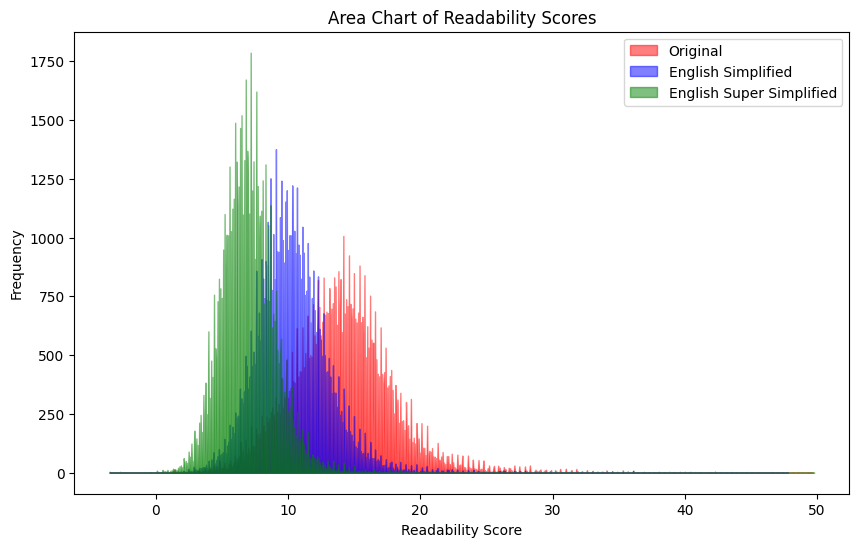

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# We filter out records having very high readability to get a better plot
filter_out = 50
filtered_df = readability_df[
    (readability_df['original']<filter_out) &
    (readability_df['english simplified']<filter_out) &
    (readability_df['english super simplified']<filter_out)
]
print(f'Skipped records: {len(readability_df)-len(filtered_df)} out of {len(readability_df)}.')

# Calculate histogram data for each readability measure
bins = 1000
hist_original, bins_original = np.histogram(filtered_df['original'], bins=bins)
hist_simplified, bins_simplified = np.histogram(filtered_df['english simplified'], bins=bins)
hist_super_simplified, bins_super_simplified = np.histogram(filtered_df['english super simplified'], bins=bins)

# Calculate the bin centers
bin_centers_original = 0.5 * (bins_original[:-1] + bins_original[1:])
bin_centers_simplified = 0.5 * (bins_simplified[:-1] + bins_simplified[1:])
bin_centers_super_simplified = 0.5 * (bins_super_simplified[:-1] + bins_super_simplified[1:])

# Plotting the area charts
plt.figure(figsize=(10, 6))

# Area chart for the original readability scores in red
plt.fill_between(bin_centers_original, hist_original, color='red', alpha=0.5, label='Original')

# Area chart for the english simplified readability scores in blue
plt.fill_between(bin_centers_simplified, hist_simplified, color='blue', alpha=0.5, label='English Simplified')

# Area chart for the english super simplified readability scores in green
plt.fill_between(bin_centers_super_simplified, hist_super_simplified, color='green', alpha=0.5, label='English Super Simplified')

# Adding labels and title
plt.xlabel('Readability Score')
plt.ylabel('Frequency')
plt.title('Histogram of Readability Scores')
plt.legend()

# Show plot
plt.show()

### Semantic similarity

In [ ]:
from metrics import bertscore

In [4]:
from tqdm import tqdm

filtered = {
    'original': [],
    'predictions': [],
    'predictions2': []
}
for i in tqdm(range(len(sources))):
    if isinstance(original[i], str) and isinstance(predictions[i], str) and isinstance(predictions2[i], str):
        filtered['original'].append(original[i])
        filtered['predictions'].append(predictions[i])
        filtered['predictions2'].append(predictions2[i])
        filtered['source'].append(sources[i])

100%|██████████| 64493/64493 [00:00<00:00, 933964.65it/s]


In [ ]:
batch_size = 100
semantic = {
    'english simplified': list(),
    'english super simplified': list(),
    'source': list()
}

for i in tqdm(range(0, len(filtered['original']), batch_size)):
    semantic['english simplified'] += [float(n) for n in bertscore(filtered['original'][i:i+batch_size], filtered['predictions'][i:i+batch_size], mean=False)]
    semantic['english super simplified'] += [float(n) for n in bertscore(filtered['original'][i:i+batch_size], filtered['predictions2'][i:i+batch_size], mean=False)]
    semantic['source'] += filtered['source'][i:i+batch_size]

In [9]:
semantic_df = pd.DataFrame(semantic)
semantic_df

,english simplified,english super simplified,source
0,0.712156,0.644274,PubMed
1,0.732753,0.583812,PubMed
2,0.662488,0.636288,PubMed
3,0.696506,0.639520,PubMed
4,0.760953,0.570686,PubMed
...,...,...,...
64329,0.729805,0.612833,Cochrane
64330,0.914113,0.693317,Cochrane
64331,0.711797,0.648559,Cochrane
64332,0.623496,0.577637,Cochrane


In [12]:
# Summary DataFrame with mean, median, max, and min semantic similarity scores by source with hierarchical columns
summary_df = semantic_df.groupby('source').agg({
    'english simplified': ['mean', 'median', 'max', 'min'],
    'english super simplified': ['mean', 'median', 'max', 'min']
}).reset_index()

# Adjust the column names to create a MultiIndex (hierarchical columns)
summary_df.columns = pd.MultiIndex.from_tuples([
    ('', 'source'),
    ('simplified', 'mean'), ('simplified', 'median'), ('simplified', 'max'), ('simplified', 'min'),
    ('super simplified', 'mean'), ('super simplified', 'median'), ('super simplified', 'max'), ('super simplified', 'min')
])

summary_df

simplified                          super simplified            \
      source       mean    median  max       min             mean    median   
0   Cochrane   0.707990  0.710033  1.0  0.454083         0.618399  0.622211   
1     PubMed   0.704669  0.697860  1.0  0.404914         0.629380  0.627792   
2  Wikipedia   0.807079  0.810888  1.0  0.325815         0.690431  0.689222   

                       
        max       min  
0  0.927472  0.393223  
1  0.929741  0.370020  
2  0.972869  0.344548

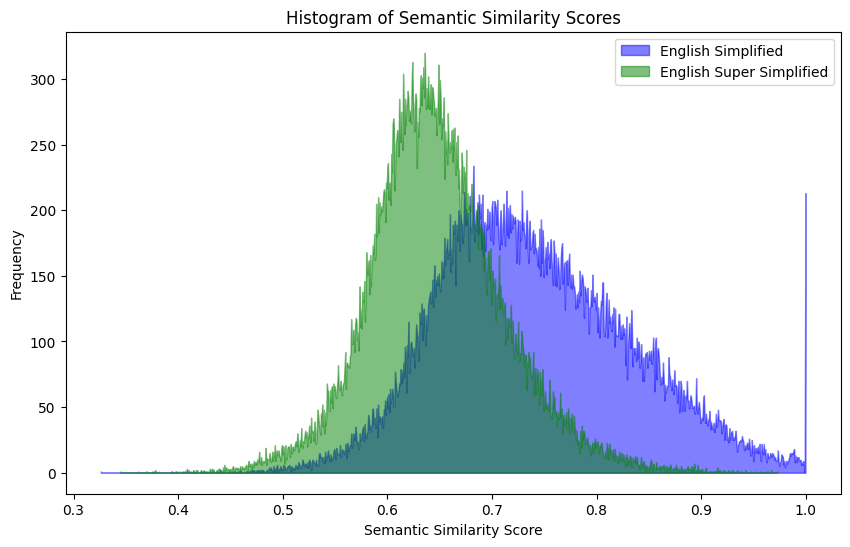

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Calculate histogram data for each semantic measure
bins = 1000
hist_simplified, bins_simplified = np.histogram(semantic_df['english simplified'], bins=bins)
hist_super_simplified, bins_super_simplified = np.histogram(semantic_df['english super simplified'], bins=bins)

# Calculate the bin centers
bin_centers_simplified = 0.5 * (bins_simplified[:-1] + bins_simplified[1:])
bin_centers_super_simplified = 0.5 * (bins_super_simplified[:-1] + bins_super_simplified[1:])

# Plotting the area charts
plt.figure(figsize=(10, 6))

# Area chart for the english simplified readability scores in blue
plt.fill_between(bin_centers_simplified, hist_simplified, color='blue', alpha=0.5, label='English Simplified')

# Area chart for the english super simplified readability scores in green
plt.fill_between(bin_centers_super_simplified, hist_super_simplified, color='green', alpha=0.5, label='English Super Simplified')

# Adding labels and title
plt.xlabel('Semantic Similarity Score')
plt.ylabel('Frequency')
plt.title('Histogram of Semantic Similarity Scores')
plt.legend()

# Show plot
plt.show()

### World cloud of blocked words

In [16]:
import os
import pandas as pd

blocked_records = list()

In [17]:
# PubMed
results_dir = 'results/markdown_pubmed'
data_dir = 'data'
df = pd.read_csv(f'{data_dir}/PubMed_articles_cleaned.tsv', sep='\t')
abstracts = df['abstract'].tolist()
gen_record_indices = [int(n.split('.')[0]) for n in os.listdir(results_dir) if '.md' in n]

blocked_records += [abstract for index, abstract in enumerate(abstracts) if index not in gen_record_indices]

In [21]:
# Wikipedia
results_dir = 'results/markdown_wiki'
data_dir = 'data'
df = pd.read_csv(f'{data_dir}/Wikipedia_articles_cleaned.tsv', sep='\t')
abstracts = df['abstract'].tolist()
gen_record_indices = [int(n.split('.')[0]) for n in os.listdir(results_dir) if '.md' in n]

blocked_records += [abstract for index, abstract in enumerate(abstracts) if index not in gen_record_indices]

In [20]:
# Cochrane
results_dir = 'results/markdown_cochrane'
data_dir = 'data'
df = pd.read_csv(f'{data_dir}/Cochrane.tsv', sep='\t')
abstracts = df['abstract'].tolist()
gen_record_indices = [int(n.split('.')[0]) for n in os.listdir(results_dir) if '.md' in n]

blocked_records += [abstract for index, abstract in enumerate(abstracts) if index not in gen_record_indices]

In [39]:
badwords_df = pd.read_csv('hurtlex_EN.tsv', sep='\t')
bad_words = badwords_df['lemma'].tolist()
bad_words = [word.lower() for word in set(badwords) if len(word)>4] # duplicates present

In [40]:
data = []
for record in blocked_records:
    data += [bad_word for bad_word in bad_words if bad_word in record.lower()]

In [41]:
4len(data)

169173

In [48]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from collections import Counter

def get_top_words_frequency(word_list, top_n=20):
    # Get the set of English stop words
    stop_words = set(stopwords.words('english'))
    
    # Filter out stop words from the word list
    filtered_words = [word for word in word_list if word.lower() not in stop_words]
    
    # Count frequencies of each word in the filtered list
    word_counts = Counter(filtered_words)
    
    # Get the top n words and their frequencies
    top_words = word_counts.most_common(top_n)
    
    return top_words

top_words_frequency = get_top_words_frequency(data, 10000)

# Print the top words and their frequencies
for word, freq in top_words_frequency:
    print(f'{word}: {freq}')

se: 13152
con: 8969
rat: 7034
red: 6127
rom: 5414
ass: 4998
eff: 4273
imp: 4208
low: 3860
ring: 3524
die: 3470
base: 3467
go: 3216
cur: 2545
ire: 2481
kin: 2048
alu: 1828
king: 1622
people: 1617
lie: 1468
mme: 1443
set: 1375
know: 1320
mean: 1229
different: 1228
nag: 1203
common: 1145
rot: 1126
ox: 1093
cross: 1074
prof: 1064
pea: 1043
roac: 1041
roach: 1010
thos: 900
ewe: 894
mac: 891
factor: 842
train: 836
process: 819
loo: 810
scribe: 786
rag: 780
rip: 734
cop: 699
bed: 654
disorder: 635
hot: 629
ira: 623
quest: 614
owl: 608
abstract: 594
gula: 585
rage: 572
black: 556
problem: 550
tool: 548
mad: 541
blood: 519
cad: 517
usual: 481
face: 479
race: 469
severe: 462
poor: 455
story: 452
sly: 452
priate: 446
score: 435
git: 418
mark: 415
rout: 409
power: 395
firm: 368
force: 365
sod: 364
kill: 354
rape: 351
tail: 350
infant: 348
family: 346
agent: 345
bus: 341
member: 338
nut: 329
beg: 323
sept: 322
blind: 313
degree: 311
minister: 308
white: 303
pass: 301
lot: 289
head: 289
infants: 285

[nltk_data] Downloading package stopwords to
[nltk_data]     /scratch/pawsey0989/nepython/mental_health/nltk_data..
[nltk_data]     .
[nltk_data]   Package stopwords is already up-to-date!


In [46]:
!pip install -q wordcloud


[notice] A new release of pip is available: 23.1.2 -> 24.1.1
[notice] To update, run: pip install --upgrade pip


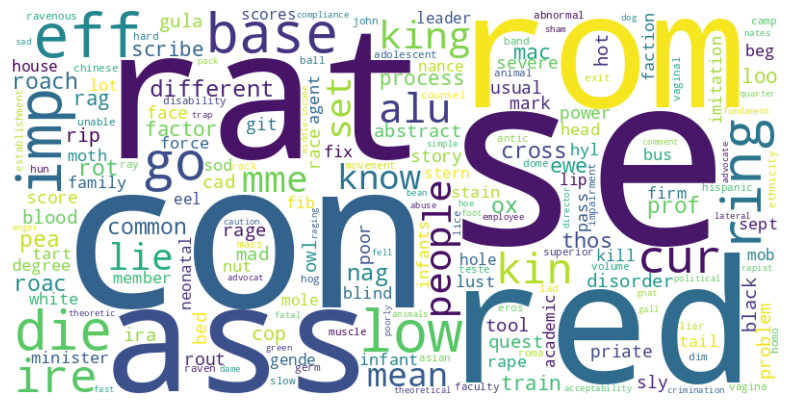

In [49]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Convert the list of tuples into a dictionary
word_freq_dict = dict(top_words_frequency)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_dict)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # No axis for the word cloud
plt.show()